In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Mean Squared Errror

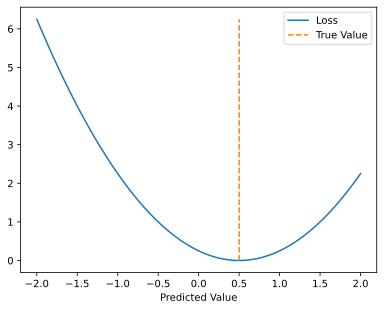

In [2]:
loss_fun = nn.MSELoss()

y_hat = torch.linspace(-2, 2, 101)
y = torch.tensor(0.5)

loss = np.zeros(101)
for i, y_pred in enumerate(y_hat):
    loss[i] = loss_fun(y_pred, y)

plt.plot(y_hat, loss, label="Loss")
plt.plot([y, y], [0, np.max(loss)], '--', label="True Value")
plt.xlabel("Predicted Value")
plt.legend();

# Binary Cross Entropy

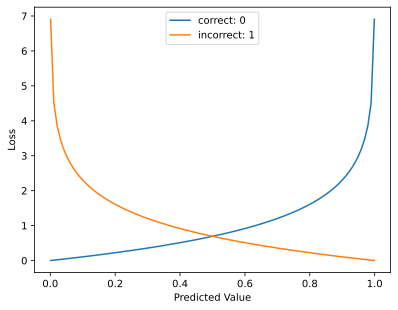

In [3]:
loss_fun = nn.BCELoss()

y_hat = torch.linspace(0.001, 0.999, 101)
y1 = torch.tensor(0.0)
y2 = torch.tensor(1.0)

loss = np.zeros((101, 2))
for i, y_pred in enumerate(y_hat):
    loss[i, 0] = loss_fun(y_pred, y1)
    loss[i, 1] = loss_fun(y_pred, y2)

plt.plot(y_hat, loss)
plt.xlabel("Predicted Value")
plt.ylabel("Loss")
plt.legend(["correct: 0", "incorrect: 1"]);

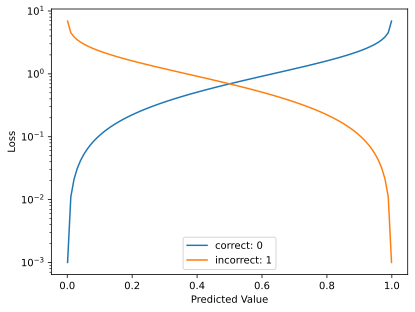

In [4]:
plt.plot(y_hat, loss)
plt.xlabel("Predicted Value")
plt.ylabel("Loss")
plt.legend(["correct: 0", "incorrect: 1"])
plt.yscale('log');

In [5]:
y_hat = torch.tensor(2.0)
sigm = nn.Sigmoid()
print(loss_fun(sigm(y_hat), y2))

tensor(0.1269)


In [6]:
loss_fun = nn.BCEWithLogitsLoss()
print(loss_fun(y_hat, y))

tensor(1.1269)


# Categorical Cross Entropy

In [7]:
loss_fun = nn.CrossEntropyLoss()

y_hat = torch.tensor([[1.0, 3.02, 3]])

for i in range(3):
    correct_answer = torch.tensor([i])
    loss = loss_fun(y_hat, correct_answer).item()
    print(loss)

2.7680397033691406
0.7480397820472717
0.7680397629737854


In [8]:
soft = nn.Softmax(dim=1)
y_hat_soft = soft(y_hat)

print(y_hat_soft)

tensor([[0.0628, 0.4733, 0.4639]])


In [9]:
log_soft = nn.LogSoftmax(dim=1)
y_hat_log_soft = log_soft(y_hat)

print(y_hat)
print(y_hat_soft)
print(y_hat_log_soft)

tensor([[1.0000, 3.0200, 3.0000]])
tensor([[0.0628, 0.4733, 0.4639]])
tensor([[-2.7680, -0.7480, -0.7680]])


# Creating the Loss Function

In [10]:
class lossFunction(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x, y):
        loss = torch.abs(x-y)
        return loss

loss_fun = lossFunction()
loss_fun(torch.tensor(4.0), torch.tensor(5.5))

tensor(1.5000)

# Three-Armies Classification

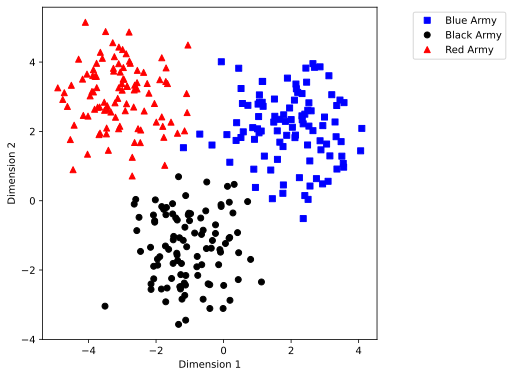

In [11]:
nPerClust = 100

A = [2, 2]
B = [-1, -1.5]
C = [-3, 3]
np.random.seed(20)
a = [A[0]+np.random.randn(nPerClust), A[1]+np.random.randn(nPerClust)]
b = [B[0]+np.random.randn(nPerClust), B[1]+np.random.randn(nPerClust)]
c = [C[0]+np.random.randn(nPerClust), C[1]+np.random.randn(nPerClust)]

labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1)), np.ones((nPerClust, 1))+1))
data_np = np.hstack((a, b, c)).T

data_tensor = torch.tensor(data_np).float()
labels_tensor = torch.squeeze(torch.tensor(labels_np).long())

plt.figure(figsize=(6,6))
plt.plot(data_tensor[np.where(labels_tensor==0)[0],0],data_tensor[np.where(labels_tensor==0)[0],1],'bs')
plt.plot(data_tensor[np.where(labels_tensor==1)[0],0],data_tensor[np.where(labels_tensor==1)[0],1],'ko')
plt.plot(data_tensor[np.where(labels_tensor==2)[0],0],data_tensor[np.where(labels_tensor==2)[0],1],'r^')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(["Blue Army", "Black Army", "Red Army"], bbox_to_anchor=(1.4,1));

In [12]:
train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=0.2)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [13]:
armyClassy = nn.Sequential(nn.Linear(2, 8), nn.ReLU(), nn.Linear(8, 8), nn.ReLU(), nn.Linear(8, 3))

loss_fun = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(armyClassy.parameters(), lr=0.01)

In [14]:
def trainModel():
    num_epochs = 200
    
    losses = torch.zeros(num_epochs)
    train_acc = []
    test_acc = []
    
    for epoch in range(num_epochs):
        
        armyClassy.train()
        
        batch_acc = []
        batch_loss = []
        
        for x, y in train_loader:
            y_hat = armyClassy(x)
            
            loss = loss_fun(y_hat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            
            batch_acc.append(100*torch.mean((torch.argmax(y_hat, axis=1) == y).float()))
            
        train_acc.append(np.mean(batch_acc))
        
        losses[epoch] = np.mean(batch_loss)
        
        armyClassy.eval()
        x, y = next(iter(test_loader))
        with torch.no_grad():
            test_acc.append(100*torch.mean((torch.argmax(armyClassy(x), axis=1) == y).float()))
    
    return train_acc, test_acc, losses

In [15]:
train_acc, test_acc, losses = trainModel()

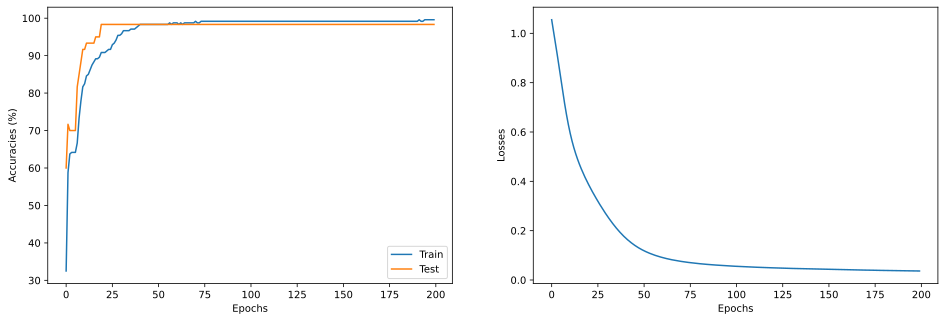

In [16]:
_, axis = plt.subplots(1, 2, figsize=(16, 5))
axis[0].plot(train_acc, label="Train")
axis[0].plot(test_acc, label="Test")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Accuracies (%)")
axis[0].legend()

axis[1].plot(losses.detach())
axis[1].set_ylabel("Losses")
axis[1].set_xlabel("Epochs");

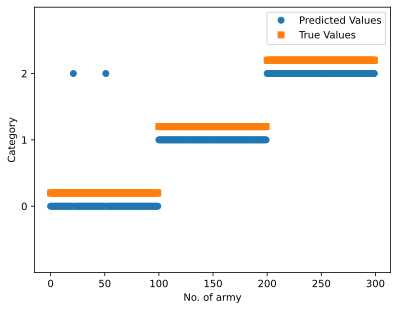

In [17]:
y_hat = armyClassy(data_tensor)
predictions = torch.argmax(y_hat, axis=1)

plt.plot(predictions, 'o', label="Predicted Values")
plt.plot(labels_tensor+0.2, 's', label="True Values")
plt.xlabel("No. of army")
plt.ylabel("Category")
plt.yticks([0, 1, 2])
plt.ylim([-1, 3])
plt.legend();

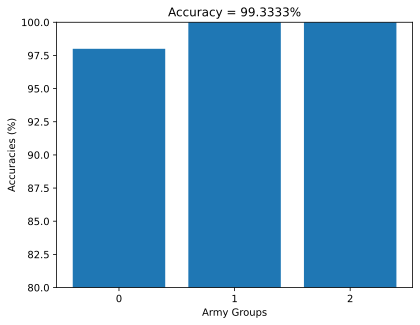

In [18]:
accuracy = (predictions == labels_tensor).float()
total_accuracy = torch.mean(100*accuracy).item()

accuracy_by_group = np.zeros(3)

for i in range(3):
    accuracy_by_group[i] = 100*torch.mean(accuracy[labels_tensor == i])
    
plt.bar(range(3), accuracy_by_group)
plt.ylim([80, 100])
plt.xticks([0, 1, 2])
plt.title("Accuracy = %g%%" %total_accuracy)
plt.ylabel("Accuracies (%)")
plt.xlabel("Army Groups");

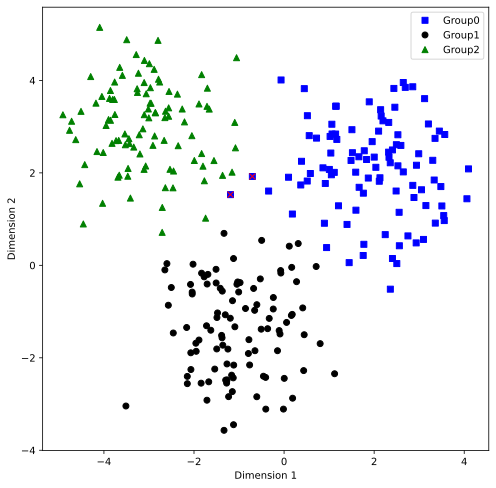

In [19]:
color_shapes = ['bs', 'ko', 'g^']

plt.figure(figsize=(8, 8))

for i in range(3):
    plt.plot(data_tensor[labels_tensor == i, 0], data_tensor[labels_tensor == i, 1], color_shapes[i], label=f"Group{i}")
    
    indexError = (accuracy == 0) & (labels_tensor == i)
    plt.plot(data_tensor[indexError, 0], data_tensor[indexError, 1], 'rx')

plt.ylabel("Dimension 2")
plt.xlabel("Dimension 1")
plt.legend();